<a href="https://colab.research.google.com/github/edwin-yan/Passion-Fruit-Disease-Detection/blob/andrew/Image_Augmentation_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Augmentation

Using this library to do image augmentation
https://towardsdatascience.com/tensorflow-and-image-augmentation-3610c6c243a2

# SET UP
## Mounting

Note that this assumes that your google drive folder has the same document layout. You must modify if that is not the case.


From your root Google Drive directory create a couple of folders:
* `JHU/DNN/FinalProject/Train_Images`
* `JHU/DNN/FinalProject/Test_Images` 

with Train and test images unzipped in those directories



# **TODO:** GLOBAL VARIABLE set to `True` if using colab and `False` if not!

In [ ]:
IS_COLAB = True 

# **TODO:** CHANGE `IMG_DIR` if your google drive directory is different

In [ ]:
if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  IMG_PATH = '/content/drive/MyDrive/JHU/DNN/FinalProject'
else:
  IMG_PATH= '.'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TRAIN_PATH = f'{IMG_PATH}/Train.csv'
TEST_PATH = f'{IMG_PATH}/Test.csv'

In [ ]:
import time

t0 = time.time()

## Imports

In [ ]:
import tensorflow as tf

Import tf addons
For some reason colab does not allow minor version e.g. specifying 2.6

In [ ]:
!pip -q install -U tensorflow_addons > log 
import tensorflow_addons as tfa

In [ ]:
!pip install tf-image
from tf_image.core.bboxes.rotate import random_rotate
from tf_image.core.random import random_function_bboxes

In [ ]:
# Clone from repo and cd into repo
!git clone https://github.com/edwin-yan/Passion-Fruit-Disease-Detection

# Change directory
%cd Passion-Fruit-Disease-Detection

# Checkout specific branch
!git checkout andrew

Cloning into 'Passion-Fruit-Disease-Detection'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (342/342), done.
remote: Compressing objects: 100% (271/271), done.
remote: Total 342 (delta 141), reused 198 (delta 56), pack-reused 0
Receiving objects: 100% (342/342), 174.90 MiB | 15.88 MiB/s, done.
Resolving deltas: 100% (141/141), done.
/content/Passion-Fruit-Disease-Detection/Passion-Fruit-Disease-Detection/Passion-Fruit-Disease-Detection/Passion-Fruit-Disease-Detection
Branch 'andrew' set up to track remote branch 'andrew' from 'origin'.
Switched to a new branch 'andrew'


In [ ]:
!ls

Baseline_Model.ipynb					      README.md
Eager_few_shot_od_training_colab_DNN_FINAL.ipynb	      Test.csv
EDA_colab.ipynb						      Test_Images
EDA.ipynb						      Train_colab.ipynb
helper.py						      Train.csv
inference_colab.ipynb					      Train_Images
Interactive_eager_few_shot_od_training_colab_DNN_FINAL.ipynb  yolo5Input
Models


In [ ]:
import pandas as pd
from helper import plot_sample_images, plot_sample_images_multi

In [ ]:
df_train, df_test = pd.read_csv(TRAIN_PATH), pd.read_csv(TEST_PATH)
print(f"Training Data Shape:  {df_train.shape}\nTest Data Shape:      {df_test.shape}")

Training Data Shape:  (3906, 6)
Test Data Shape:      (931, 1)


In [ ]:
df_train.Image_ID.value_counts().head(10)

ID_M34YFAR2    5
ID_LZI2KVVE    5
ID_AF7K88JS    5
ID_OYN556Y0    5
ID_XEMG90OT    5
ID_13DOIJXI    4
ID_66FB5PP0    4
ID_HAC2KQXS    4
ID_3OTYB2MG    4
ID_I2WILH68    4
Name: Image_ID, dtype: int64

In [ ]:
df_train['class'].value_counts()

fruit_healthy      1638
fruit_woodiness    1246
fruit_brownspot    1022
Name: class, dtype: int64

In [ ]:
# plot_sample_images_multi(df_train,dir_path=IMG_PATH)

In [ ]:
# plot_sample_images_multi(df_test, show_label=False, is_train=False,dir_path=IMG_PATH)

Try Image Augmentation

I think the require format is https://github.com/Ximilar-com/tf-image/blob/master/tf_image/core/bboxes/rotate.py

 [ymin, xmin, ymin, xmax].

## FIRST update the df_train

In [ ]:
IMG_HEIGHT = 512
IMG_WIDTH = 512

In [ ]:
df_train.head()

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0


In [ ]:
# get xmax
df_train['xmax'] = df_train['xmin'] + df_train['width']
# get ymax
df_train['ymax'] = df_train['ymin'] + df_train['height']

In [ ]:
df_train

,Image_ID,class,xmin,ymin,width,height,xmax,ymax
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0,315.0,398.5
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5,342.5,372.0
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5,404.5,512.0
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0,379.5,410.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0,313.0,414.5
...,...,...,...,...,...,...,...,...
3901,ID_ZZAB1FH1,fruit_healthy,96.0,175.5,289.5,222.0,385.5,397.5
3902,ID_ZZAB1FH1,fruit_healthy,330.0,241.0,182.0,180.5,512.0,421.5
3903,ID_ZZJZ2CV6,fruit_healthy,358.0,234.0,134.5,107.0,492.5,341.0
3904,ID_ZZJZ2CV6,fruit_healthy,98.5,135.0,275.5,213.5,374.0,348.5


In [ ]:
df_train.loc[df_train['Image_ID'] == 'ID_007FAIEI']['xmin'].values[0]

87.0

In [ ]:
train_toRotate_path = f'{IMG_PATH}/Train_Images/ID_007FAIEI.jpg'

BEFORE ROTATE

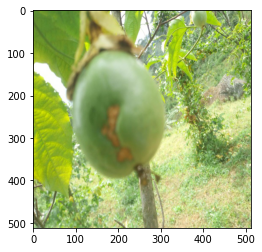

In [ ]:
import matplotlib.image as img
import matplotlib.pyplot as plt

image = img.imread(train_toRotate_path)
plt.imshow(image)
 

In [ ]:
image = tf.io.read_file(train_toRotate_path)


In [ ]:
xmin_toRot = df_train.loc[df_train['Image_ID'] == 'ID_007FAIEI']['xmin'].values[0]
ymin_toRot = df_train.loc[df_train['Image_ID'] == 'ID_007FAIEI']['ymin'].values[0]
xmax_toRot = df_train.loc[df_train['Image_ID'] == 'ID_007FAIEI']['xmax'].values[0]
ymax_toRot = df_train.loc[df_train['Image_ID'] == 'ID_007FAIEI']['ymax'].values[0]
bounding_boxes = tf.constant([[xmin_toRot, ymin_toRot, xmax_toRot, ymax_toRot]])
bounding_boxes

<tf.Tensor: shape=(1, 4), dtype=float64, numpy=array([[ 87. ,  87.5, 315. , 398.5]])>

In [ ]:
image = tf.image.decode_jpeg(image)


ValueError: ignored

In [ ]:

# rotate every time
image_rot, bounding_boxes_rot = random_function_bboxes(
    image, bounding_boxes, random_rotate, prob=0.8, min_rotate=-180, max_rotate=180
)

In [ ]:
import numpy as np
rotatedBB = (np.array(bounding_boxes_rot)*512)[0]
rotatedBB

array([512.        , 162.95811462, 512.        , 162.95811462])

In [ ]:
image_rot

<tf.Tensor: shape=(695, 695, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>

https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image

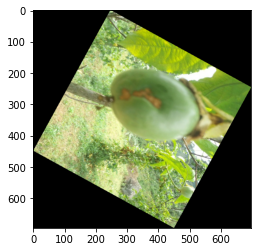

In [ ]:
fig, ax = plt.subplots()
from matplotlib.patches import Rectangle
ax.imshow(image_rot)
rect = Rectangle((rotatedBB[1],rotatedBB[0]),rotatedBB[3]-rotatedBB[1],rotatedBB[2]-rotatedBB[0], linewidth=1, edgecolor='r', facecolor='none')

ax.add_patch(rect)
plt.show()

# MID